<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/lidc_transfer_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ERM CNN Model for Malignancy

#First We setup the repo

In [22]:
# Only run if on Colab
#%cd .. #run this on local machine
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3329, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 3329 (delta 248), reused 350 (delta 205), pack-reused 2925
Receiving objects: 100% (3329/3329), 56.11 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (3060/3060), done.
Checking out files: 100% (5393/5393), done.
/content/LIDC_GDRO


In [30]:
# !git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/mtzig/LIDC_GDRO
   3c921ee..758af5a  main       -> origin/main
Updating 3c921ee..758af5a
Fast-forward
 image_data_utils.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import torch
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import VGGNet, ResNet18
from loss import ERMLoss, GDROLossAlt, GDROLoss
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision

In [25]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


#Test Models

In [26]:
import torch.nn as nn

class testModel(nn.Module):

    def __init__(self, device='cpu', pretrained=True, freeze=True):
        super(testModel, self).__init__()

        self.model = torchvision.models.resnet18(pretrained=pretrained).to(device) #torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False


            # for param in self.model.layer4.parameters():
            #     param.requires_grad = True

        self.model.fc = nn.Sequential(
          nn.Linear(in_features=512, out_features=36, bias=True, device=device),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=36, out_features=2, bias=True, device=device)
          # nn.Linear(in_features=36, out_features=1, bias=True, device=device)
        )

        for layer in self.model.fc:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x).squeeze()


#Next We get our data

## Now we get the data

In [32]:
from image_data_utils import getImages, getTrainValSplit, getSubtypedDataLoader

In [64]:
train_data, test_data = getImages(device=DEVICE)

train_split = SubclassedNoduleDataset(*train_data)

test_set = SubclassedNoduleDataset(*test_data)
train_set, val_set = getTrainValSplit(train_set, split_percent = 0.95)

In [120]:
# train_loader = getSubtypedDataLoader(train_set,5)

In [125]:
val_loader = InfiniteDataLoader(val_set, len(val_set))
test_loader = InfiniteDataLoader(test_set, len(test_set))

In [126]:
train_loader = InfiniteDataLoader(train_set, 128)

#Now we create the model and setup training

First we make our model

In [136]:
model = testModel(device=DEVICE, pretrained=True, freeze=False)

In [137]:
# loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
# loss_fn = GDROLoss(model,torch.nn.CrossEntropyLoss(),{'groupdro_eta':0.01}, )
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)

loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.1, 4) 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)

# loss_fn = ERMLoss(model,torch.nn.functional.binary_cross_entropy_with_logits,{})


We also make learning rate scheduler

In [138]:
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

##Now we train the model

In [139]:
epochs = 15#40
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(train_loader, model, loss_fn, optimizer, verbose=True)
    accuracies = test(val_loader, model, verbose=True)
    scheduler.step(min(accuracies[1:]))

Epoch 1/15
Average training loss: 0.8673823841593482
Accuracy: 0.7491749174917491 
Accuracy over subgroups: [0.33333333 0.60135135 0.97826087 0.8627451 ] 
Worst Group Accuracy: 0.3333333333333333
Epoch 2/15
Average training loss: 0.483043645593253
Accuracy: 0.7722772277227723 
Accuracy over subgroups: [0.3        0.71875    0.91358025 0.80769231] 
Worst Group Accuracy: 0.3
Epoch 3/15
Average training loss: 0.42489313605156814
Accuracy: 0.7392739273927392 
Accuracy over subgroups: [0.38095238 0.7983871  0.79775281 0.66666667] 
Worst Group Accuracy: 0.38095238095238093
Epoch 4/15
Average training loss: 0.3468688147311861
Accuracy: 0.7491749174917491 
Accuracy over subgroups: [0.5        0.81081081 0.73076923 0.68253968] 
Worst Group Accuracy: 0.5
Epoch 5/15
Average training loss: 0.26301669668067584
Accuracy: 0.8052805280528053 
Accuracy over subgroups: [0.77272727 0.88028169 0.84146341 0.57894737] 
Worst Group Accuracy: 0.5789473684210527
Epoch 6/15
Average training loss: 0.224936500530

#Lastly We evaluate model performance

##Model Performance on Test Set

In [140]:
#spaghetti code-esque way to get imgs and labels for entire test set
accuracies = test(test_loader, model, verbose=False)

print(f'spiculated benign accuracy: {accuracies[1]:.3f}')
print(f'unspiculated benign accuracy: {accuracies[2]:.3f}')
print(f'spiculated malignant accuracy: {accuracies[3]:.3f}')
print(f'unspiculated malignant accuracy: {accuracies[4]:.3f}')

print(f'Total accuracy: {accuracies[0]:.3f}')

spiculated benign accuracy: 0.905
unspiculated benign accuracy: 0.869
spiculated malignant accuracy: 0.941
unspiculated malignant accuracy: 0.778
Total accuracy: 0.882


##saving model for gdro

In [ ]:
weight_path = os.path.join('/content', 'LIDC_GDRO', 'weights')
# torch.save(model.state_dict(), weight_path) #saves weights in file called weights

In [ ]:
model = testModel(device=DEVICE, pretrained=False, freeze=True) #model with gradients frozen 
model.load_state_dict(torch.load(weight_path, map_location="cuda:0")) #loads it in
model.model.fc = nn.Sequential(
        nn.Linear(in_features=512, out_features=36, bias=True, device=DEVICE),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        # nn.Linear(in_features=36, out_features=36, bias=True, device=DEVICE),
        # nn.ReLU(inplace=True),
        # nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=36, out_features=2, bias=True, device=DEVICE)
        # nn.Linear(in_features=36, out_features=1, bias=True, device=device)
      )

for layer in model.model.fc:
  if hasattr(layer, 'weight'):
    nn.init.xavier_uniform_(layer.weight)

In [ ]:
loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),1, 4) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)#lr=0.001, weight_decay=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

# Run of 30 test

In [ ]:
accuracies = []
for run in range(1,16):
  model = testModel(device=DEVICE, pretrained=True, freeze=False)
  loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True) #torch.nn.functional.binary_cross_entropy_with_logits
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

  epochs = 15#40
  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(train_loader, model, loss_fn, optimizer, verbose=True)
    accuracies = test(val_loader, model, verbose=True)
    scheduler.step(min(accuracies[1:]))

  all_test_imgs = marked_benign+unmarked_benign+marked_malignant+unmarked_malignant
  all_labels = torch.tensor([0 for _ in marked_benign+unmarked_benign]+[1 for _ in marked_malignant+unmarked_malignant], device=DEVICE)


  print(f'spiculated benign accuracy: {get_sensitivity(model, marked_benign, 0):.3f}')
  print(f'unspiculated benign accuracy: {get_sensitivity(model, unmarked_benign, 0):.3f}')
  print(f'spiculated malignant accuracy: {get_sensitivity(model, marked_malignant, 1):.3f}')
  print(f'unspiculated malignant accuracy: {get_sensitivity(model, unmarked_malignant, 1):.3f}')

  print(f'Total accuracy: {get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True):.3f}')
  accuracies.append((get_sensitivity(model, marked_benign, 0),
                     get_sensitivity(model, unmarked_benign, 0),
                     get_sensitivity(model, marked_malignant, 1),
                     get_sensitivity(model, unmarked_malignant, 1),
                     get_sensitivity(model, all_test_imgs, all_labels, label_tensor=True)))

Epoch 1/15
Average training loss: 0.4821816821893056
cv accuracy 0.7899999618530273
Epoch 2/15
Average training loss: 0.3447404861450195
cv accuracy 0.8499999642372131
Epoch 3/15
Average training loss: 0.2742716550827026
cv accuracy 0.7949999570846558
Epoch 4/15
Average training loss: 0.24979658193058438
cv accuracy 0.699999988079071
Epoch 5/15
Average training loss: 0.23685321178701188
cv accuracy 0.7949999570846558
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Average training loss: 0.15020877454015943
cv accuracy 0.8499999642372131
Epoch 7/15
Average training loss: 0.07932834037476116
cv accuracy 0.8050000071525574
Epoch 8/15
Average training loss: 0.05756882085568375
cv accuracy 0.7949999570846558
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Average training loss: 0.032509107370343474
cv accuracy 0.8799999952316284
Epoch 10/15
Average training loss: 0.02420295670421587
cv accuracy 0.8299999833106995
Epoch 11/15
Average training

KeyboardInterrupt: ignored

In [ ]:
total_acc = list(map(lambda x:x[-1], accuracies))

In [ ]:
sum(total_acc)/len(total_acc)

tensor(0.8286, device='cuda:0')

In [ ]:
accuracies = list(map(lambda x:(float(i) for i in x), accuracies))

In [ ]:
df = pd.DataFrame(accuracies, columns = ['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'])

In [ ]:
df.head()

,marked_benign,unmarked_benign,marked_malignant,unmarked_malignant,entire
0,0.761905,0.882759,0.829268,0.754386,0.836066
1,0.714286,0.848276,0.878049,0.789474,0.836066
2,0.666667,0.868966,0.792683,0.684211,0.800000
3,0.809524,0.868966,0.841463,0.771930,0.839344
4,0.714286,0.882759,0.865854,0.754386,0.842623


In [ ]:
df.to_csv('cnn_erm_accuracies.csv')

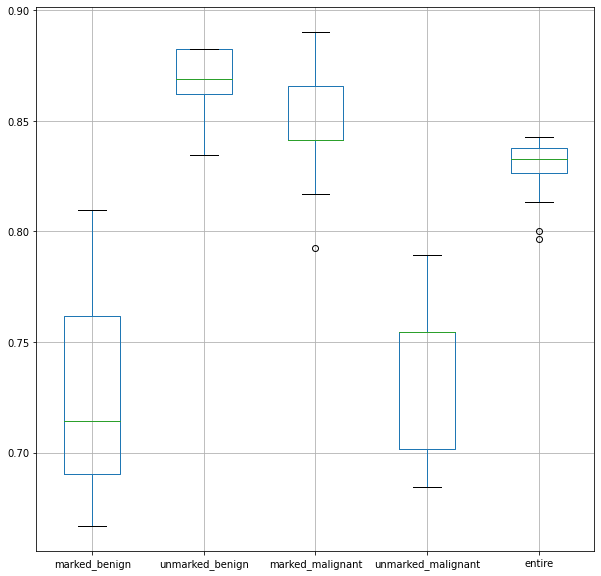

In [ ]:
boxplot = df.boxplot(column=['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'], figsize = (10,10))  

#GDRO Model Performance

In [141]:
all_accuracies = []
for run in range(1,16):
  model = testModel(device=DEVICE, pretrained=True, freeze=False)

  loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.1,4) #torch.nn.functional.binary_cross_entropy_with_logits
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)
  
  epochs = 15#40
  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(train_loader, model, loss_fn, optimizer, verbose=True)
    accuracies = test(val_loader, model, verbose=True)
    scheduler.step(min(accuracies[1:]))

  accuracies = test(test_loader, model, verbose=False)


  print(f'spiculated benign accuracy: {accuracies[1]:.3f}')
  print(f'unspiculated benign accuracy: {accuracies[2]:.3f}')
  print(f'spiculated malignant accuracy: {accuracies[3]:.3f}')
  print(f'unspiculated malignant accuracy: {accuracies[4]:.3f}')

  print(f'Total accuracy: {accuracies[0]:.3f}')
  all_accuracies.append(accuracies)

Epoch 1/15
Average training loss: 0.7473343881693754
Accuracy: 0.7425742574257426 
Accuracy over subgroups: [0.69230769 0.75362319 0.81818182 0.625     ] 
Worst Group Accuracy: 0.625
Epoch 2/15
Average training loss: 0.5080896406011148
Accuracy: 0.8316831683168316 
Accuracy over subgroups: [0.82352941 0.88888889 0.84269663 0.66037736] 
Worst Group Accuracy: 0.660377358490566
Epoch 3/15
Average training loss: 0.4438486668196591
Accuracy: 0.768976897689769 
Accuracy over subgroups: [0.57894737 0.8343949  0.77108434 0.61363636] 
Worst Group Accuracy: 0.5789473684210527
Epoch 4/15
Average training loss: 0.35409449616616423
Accuracy: 0.759075907590759 
Accuracy over subgroups: [0.64705882 0.73825503 0.82352941 0.75      ] 
Worst Group Accuracy: 0.6470588235294118
Epoch 5/15
Average training loss: 0.2873728302392093
Accuracy: 0.7656765676567657 
Accuracy over subgroups: [0.70588235 0.8943662  0.59782609 0.73076923] 
Worst Group Accuracy: 0.5978260869565217
Epoch 00005: reducing learning rate

In [142]:
total_acc = list(map(lambda x:x[-1], all_accuracies))
sum(total_acc)/len(total_acc)

0.738851866306012

In [143]:
accuracies = list(map(lambda x:(float(i) for i in x), all_accuracies))

In [144]:
df = pd.DataFrame(accuracies, columns = ['entire', 'marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant'])

In [145]:
df.head()

,entire,marked_benign,unmarked_benign,marked_malignant,unmarked_malignant
0,0.845902,0.931034,0.863636,0.860465,0.741379
1,0.803279,0.809524,0.835616,0.778947,0.744186
2,0.836066,0.833333,0.879699,0.815217,0.767857
3,0.790164,0.681818,0.823944,0.864198,0.650000
4,0.865574,0.782609,0.856115,0.948718,0.815385


In [146]:
df.to_csv('cnn_gdro_accuracies.csv')

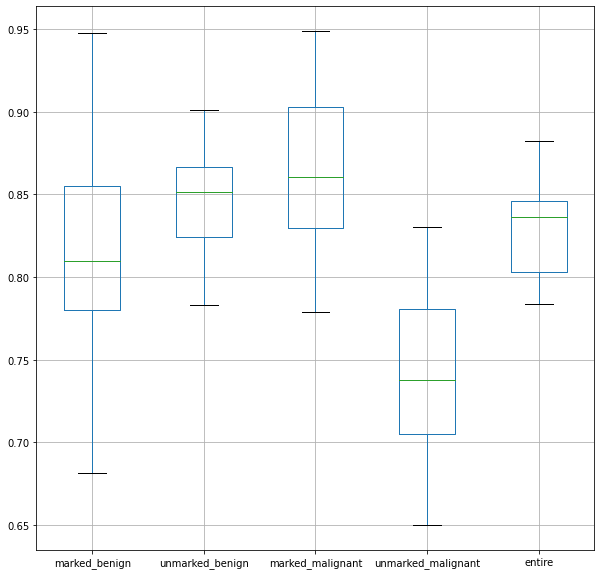

In [147]:
boxplot = df.boxplot(column=['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'], figsize = (10,10))  